## NLP Language Identification
by Stanford Gibson
### Overview
Overview
South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages.

#### Data
The dataset used for this challenge is the NCHLT Text Corpora collected by the South African Department of Arts and Culture & Centre for Text Technology (CTexT, North-West University, South Africa). The training set was improved through additional cleaning done by Praekelt.

The data is in the form Language ID, Text. The text is in various states of cleanliness. Some NLP techniques will be necessary to clean up the data.

#### The task
In this challenge, you will take text which is in any of South Africa's 11 Official languages and identify which language the text is in. This is an example of NLP's Language Identification, the task of determining the natural language that a piece of text is written in.

First we will import the relevant libraries to perform data import, manipulation, visualisation as well as model building and predicting.

In [105]:
# Libraries

# Data manipulation and visualisation
import numpy as np # mathematical processing
import pandas as pd # data manipulation
import seaborn as sns # data visualisation
from wordcloud import WordCloud # creating word clouds
import matplotlib.pyplot as plt  # data visualisation
%matplotlib inline
# set plot style
sns.set()

# Text manipulation
import nltk # toolkit for language processing
#from nltk.corpus import stopwords # redundant words
# pip install stopwordsiso
import stopwordsiso as stopwords
from nltk.corpus import wordnet
import re # regular expression for text extraction
import string # for punctuation removal
from nltk.tokenize import TreebankWordTokenizer # tokenizing words
from nltk import SnowballStemmer, PorterStemmer # stemming tool
from nltk import WordNetLemmatizer # lemmatizing tool
from sklearn import feature_extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Model building, evalution and prediction
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import f1_score, accuracy_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

import warnings
warnings.filterwarnings('ignore')
import pickle 


Next we'll import and inspect the data by printing the first five rows of each dataset as well as checking the column type and null values.

In [106]:
# Train data import 
train_df = pd.read_csv('train_set.csv')

In [107]:
# Test data import 
test_df = pd.read_csv('test_set.csv')

In [108]:
# Inspect the train data
print('First five rows of the train data:', end='\n\n')
print(train_df.head(), end='\n\n')
print('- The train data contains', train_df.shape[0], 'rows and', train_df.shape[1], 'columns')
print('-- Column 1;', train_df.columns[0], 'is the language ID which is the target / label and column 2;'
      , train_df.columns[1], 'is the feature.' )

print('\n')

# Display train datatype information:
train_df.info()

First five rows of the train data:

  lang_id                                               text
0     xho  umgaqo-siseko wenza amalungiselelo kumaziko ax...
1     xho  i-dha iya kuba nobulumko bokubeka umsebenzi na...
2     eng  the province of kwazulu-natal department of tr...
3     nso  o netefatša gore o ba file dilo ka moka tše le...
4     ven  khomishini ya ndinganyiso ya mbeu yo ewa maana...

- The train data contains 33000 rows and 2 columns
-- Column 1; lang_id is the language ID which is the target / label and column 2; text is the feature.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


The information above confirms that there are 33,000 records in the features as well as the label. So no null values to deal with. The `lang_id`, the label, and `text`, a feature is of type object.

In [109]:
#Test data inspection
print('First five rows of the test data:', end='\n\n')
print(test_df.head(), end='\n\n')
print('- The test data contains', test_df.shape[0], 'rows and', test_df.shape[1], 'columns')
print('-- Column 1;', test_df.columns[0], 'is the row index and column 2;'
      , test_df.columns[1], 'is the feature.' )

First five rows of the test data:

   index                                               text
0      1  Mmasepala, fa maemo a a kgethegileng a letlele...
1      2  Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2      3         Tshivhumbeo tshi fana na ngano dza vhathu.
3      4  Kube inja nelikati betingevakala kutsi titsini...
4      5                      Winste op buitelandse valuta.

- The test data contains 5682 rows and 2 columns
-- Column 1; index is the row index and column 2; text is the feature.


Next we'll inspect the `lang_id` column of the `train` dataset to understand how many languages are represented and what the distribution of samples are between these languages.

In [110]:
# identify the language values
language_labels = list(train_df.lang_id.unique())
print('There are', len(language_labels), 'languages represented. These are:')
print(language_labels)

There are 11 languages represented. These are:
['xho', 'eng', 'nso', 'ven', 'tsn', 'nbl', 'zul', 'ssw', 'tso', 'sot', 'afr']


We've confirmed that all 11 South African languages are represented:
* 'xho': Xhosa
* 'eng': English
* 'nso': Northern Sotho
* 'ven': Venda
* 'tsn': Tswana
* 'nbl': isiNdebele
* 'zul': Zulu
* 'ssw': siSwati
* 'tso': Tsonga
* 'sot': Sesotho
* 'afr': Afrikaans

Next we'll obtain a view of the data samples for each language.


The sample distribution per language class:


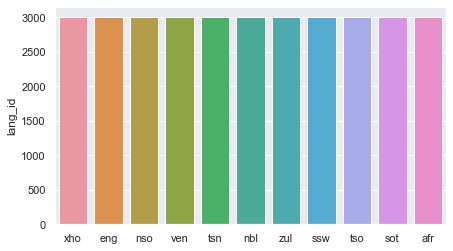

The percentage sample distribution per language class:

xho : 9%
eng : 9%
nso : 9%
ven : 9%
tsn : 9%
nbl : 9%
zul : 9%
ssw : 9%
tso : 9%
sot : 9%
afr : 9%


In [111]:
# Graphical representation of the language classes
print('\nThe sample distribution per language class:', end='\n')
plt.figure(figsize=(7,4))
sns.barplot(data=train_df, x=train_df['lang_id'].unique(), y=train_df['lang_id'].value_counts())
plt.show()

# Class Percentages:
print('The percentage sample distribution per language class:', end='\n\n')
for lang in language_labels:
    lang = train_df[train_df['lang_id'] == lang]
    print(lang['lang_id'].iloc[0],": {}%".format(round(100 * (len(lang) / (len(train_df))))))

From the barplot above we note that the data is evenly distributed between the 11 language classes, therefor each represented by 3,300 records which is 9% of the total record count. This means there is no class imbalance present in the data.

Next we'll look at the first record for each language to get a high level understanding to the language structure and word usage.

In [112]:
# Language snippets
print('First record for each language:', end='\n')

for lang in language_labels:
    lang = train_df[train_df['lang_id'] == lang]
    print("\n",lang['lang_id'].iloc[0],"\n", lang['text'].iloc[0])

First record for each language:

 xho 
 umgaqo-siseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath inxaxheba kwabafazi ezi ziquka phakathi kwezinye zazo ikomishoni yokulingana ngokwesini ikomishoni yamalungelo oluntu lomzantsi afrika

 eng 
 the province of kwazulu-natal department of transport invites tenders from established contractors experienced in bridge construction for the construction of the kwajolwayo tugela river pedestrian bridge near tugela ferry the duration of the project will be months

 nso 
 o netefatša gore o ba file dilo ka moka tše le dumelelanego ka tšona mohlala maleri a magolo a a šomišwago go fihlelela meagong e metelele scaffolds a a bolokegilego lefelo la maleba la go šomela go phela gabotse bjbj

 ven 
 khomishini ya ndinganyiso ya mbeu yo ewa maana u ya nga mulayo wa khomishini ya ndinganyiso ya mbeu u thetshelesa mbilaelo dzine dza tshimbilelana na tshialula u ya nga mbeu nahone i ivhea sa foramu ya thungo u ya nga mulayo wa ndin

From the text above it appears:
1. That the text does not contain uppercase letters and punctuation has been removed, however we will still change the text to lowercase and remove punctuation, numbers and special characters.
2. Relatively longer words in `xho`; Xhosa. 
3. Certain languages use marks on letters like `ï` in the word `geïnfekteer` used in `afr`; Afrikaans. In this case it indicates a vowel sound change. As well as (š s with caron) representing the sh sound in `netefatša`, `šomišwago` and `šomela` in `nso`; Nothern Sotho. This was not identified in the other values, however this may not be representative of the entire dataset. We will investigate further as we progress.
4. Certain languages place `i-` infront of an english term such as `i-gross domestic product` in `ssw` siSwati and `i-tip-offs` in `zul`; Zulu.

Next we'll produce word clouds to get an understanding of the most used words in each language but before doing that we will remove noise such as punctuation as well as ensure that all the text is in lowercase before applying tokenisation and lemmatisation.

### Removing Noise
We will remove unneccesary information, as seen above. These include web-urls, punctuation and stopwords. We will also convert the text to lower-case.

#### Punctuation removal
Next we will ensure text uniformity by converting all text to lower case and then removing punctuation and special characters.

In [113]:
def text_cleanup(text):
    """This function removes punctuation from text and converts 
    it to lower case """
    # Change text to lowercase
    text = text.lower()
    # Replace a dash with a space
    text = re.sub(r'-', ' ', text)
    # Remove punctuation, numbers and special characters
    text = re.sub(r'[!@#$(),"%^*?:;~`0-9]', ' ', text)
    text = re.sub(r'[[]]', ' ', text)

    return ''.join([l for l in text if l not in string.punctuation])

### Tokenization
Next we tokenize the cleaned text by splitting the entire text blocks word units.

In [114]:
# Tokenize the text
def tokenize_words(clean_text):
    """This function tokenizes the text into words"""
    # Initialise tokenizer
    tokenizer = TreebankWordTokenizer()
    
    return tokenizer.tokenize(clean_text)

### Stemming
Next we will create the stemmer object, in order to apply stemming later, the process of reducing a word to its word stem, the cleaned text.

In [115]:
# Stem the text:
stemmer = PorterStemmer()

### Lemmatization
Next we will create the lemmatization object, in order to apply lemmatization later. A lemma is the canonical form of a set of words.

In [116]:
# Create lemmatizer object
lemmatizer = WordNetLemmatizer()

### Stopwords
Next well remove the known stopwords for zulu, sotho, sothern, english and afrikaans from the text by first creating a removal function and then applying the function to the dataset.

In [117]:
def remove_stop_words(tokens):
    """ This function removes stopwords from zu - zulu, st - sotho, sothern, 
    en - english and af - afrikaans"""
    stop_words = stopwords.stopwords(['zu', 'st', 'en', 'af'])
    return [t for t in tokens if t not in stop_words]

Next we will apply all the pre-processing cleanup functions to the train data.

In [118]:
# Apply the remove_punctuation function
train_df['clean_text'] = train_df['text'].apply(text_cleanup)

# Apply the tokenization to cleaned text
train_df['clean_text'] = train_df['clean_text'].apply(tokenize_words)

# # Apply stemming to the cleaned text
# train_df['clean_text'] = train_df['clean_text'].apply(
#     lambda sentence: [stemmer.stem(word) for word in sentence])

# # Apply lemmatization to the cleaned text
# train_df['clean_text'] = train_df['clean_text'].apply(
#     lambda sentence: [lemmatizer.lemmatize(word) for word in sentence])

# Apply the remove_stop_words function
train_df['clean_text'] = train_df['clean_text'].apply(remove_stop_words)

Next we will convert the text from tokens back to sentences in order to create word clouds and to get an understanding of the word usage per language.

In [119]:
# Converting Tokens back to blocks of sentences:
def back_to_sentence(clean_text):
    """Function to convert text list back to block of text"""     
    return " ".join(clean_text)

In [120]:
# Apply the back_to_sentence function
train_df['clean_text'] = train_df['clean_text'].apply(back_to_sentence)
train_df.head()

lang_id                                               text  \
0     xho  umgaqo-siseko wenza amalungiselelo kumaziko ax...   
1     xho  i-dha iya kuba nobulumko bokubeka umsebenzi na...   
2     eng  the province of kwazulu-natal department of tr...   
3     nso  o netefatša gore o ba file dilo ka moka tše le...   
4     ven  khomishini ya ndinganyiso ya mbeu yo ewa maana...   

                                          clean_text  
0  umgaqo siseko wenza amalungiselelo kumaziko ax...  
1  dha iya kuba nobulumko bokubeka umsebenzi naph...  
2  province kwazulu natal department transport in...  
3  netefatša gore file dilo moka tše dumelelanego...  
4  khomishini ya ndinganyiso ya mbeu yo ewa maana...

### Lexicon
Next we'll create lexicon for each language.

In [121]:
# Extract words from text
def extract_words(text):
    """This function extracts the words in a piece of text"""
    word_list = []
    
    # Iteration to extract every word
    for words in text:
        word = words.split(' ')
        word_list.extend(word)
    return word_list

In [122]:
def extraction(lang):
    """This function calls on extract_words() and 
    extracts the words based on the language"""
    return extract_words(train_df['clean_text'][train_df['lang_id'] == lang])

#### Word Bible
Next we'll construct a word bible with the language and keys and the lexicon as values.

In [123]:
# Empty word bible dictionary
word_bible = {}
word_counter = []
total = 0

# Fill the word_bible
for lang in language_labels:
    word_bible[lang] = [extraction(lang),len(extraction(lang))]
    word_counter.append([lang, len(extraction(lang))])
    total += len(extraction(lang))

# Sort the word_bible
sort_word_bible = sorted(word_bible.items(),
                        key=lambda x: x[1][1], reverse=True)

# information on the word_bible
print("The word_bible (dictionary); Language and number of words:", end='\n\n')
for i in sort_word_bible:
    print(i[0], 'with', i[1][1], 'has ('+ str(round((i[1][1] / total) * 100,1)) 
          + '%) of the total word count')


The word_bible (dictionary); Language and number of words:

tso with 107750 has (12.2%) of the total word count
ven with 106040 has (12.0%) of the total word count
nso with 87081 has (9.8%) of the total word count
tsn with 83505 has (9.4%) of the total word count
sot with 82540 has (9.3%) of the total word count
xho with 78435 has (8.8%) of the total word count
ssw with 75576 has (8.5%) of the total word count
nbl with 74181 has (8.4%) of the total word count
zul with 73223 has (8.3%) of the total word count
afr with 66209 has (7.5%) of the total word count
eng with 51886 has (5.9%) of the total word count


Next we'll get a visual understanding of each languages' word makeup, by looking at the most frequently occuring words.

You will notice, from the word_bible ranking above and the word clouds below that English has a stronger, bolder, large-word representation partly due to the stopword removal (available for zulu, sotho, english and afrikaans), whereas no such resource is available for the many of the other languages. Furthermore, the below word clouds show the heavy presence of two / three character words.


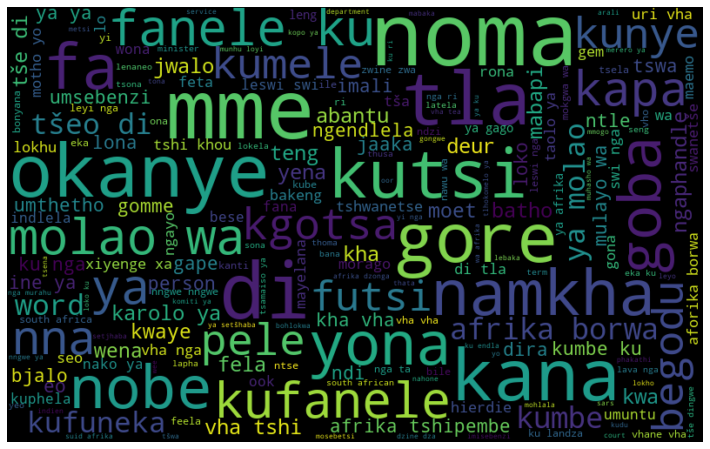

In [124]:
# Visualize the most frequent words accross all languages:
all_words = " ".join([sentence for sentence in train_df['clean_text']])

wc = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# Plot the graph:
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Next we'll look at the make-up of each indivual language.

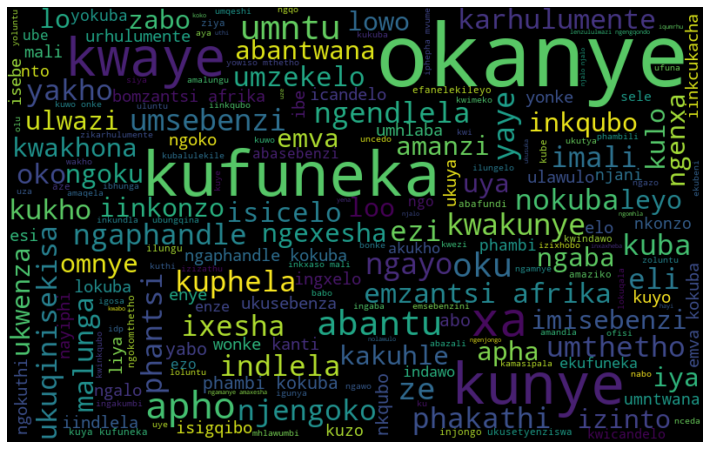

In [125]:
# Visualize Frequent words for 'xho'; Xhosa 
xho_words = " ".join([sentence for sentence in train_df['clean_text'][train_df['lang_id'] == 'xho']])

wc = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(xho_words)

# Plot the graph:
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

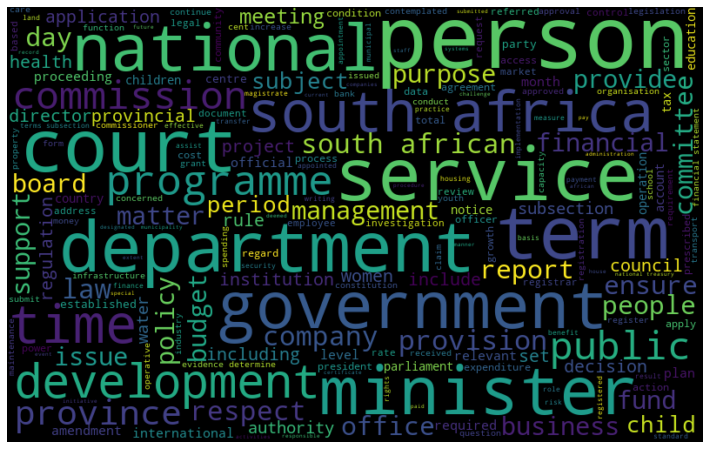

In [126]:
# Visualize Frequent words for 'eng'; English 
eng_words = " ".join([sentence for sentence in train_df['clean_text'][train_df['lang_id'] == 'eng']])

wc = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(eng_words)

# Plot the graph:
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

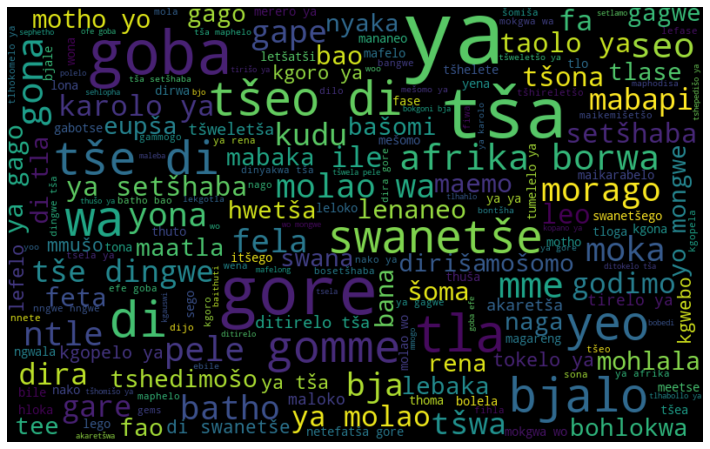

In [127]:
# Visualize Frequent words for 'nso'; Northern Sotho 
nso_words = " ".join([sentence for sentence in train_df['clean_text'][train_df['lang_id'] == 'nso']])

wc = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(nso_words)

# Plot the graph:
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

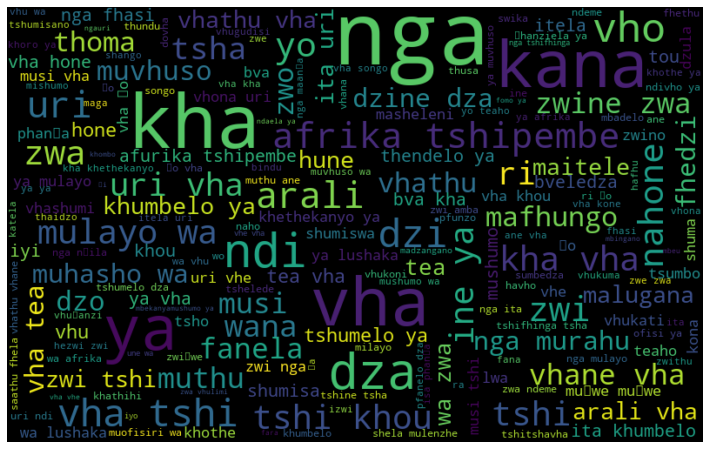

In [128]:
# Visualize Frequent words for 'ven'; Venda 
ven_words = " ".join([sentence for sentence in train_df['clean_text'][train_df['lang_id'] == 'ven']])

wc = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(ven_words)

# Plot the graph:
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

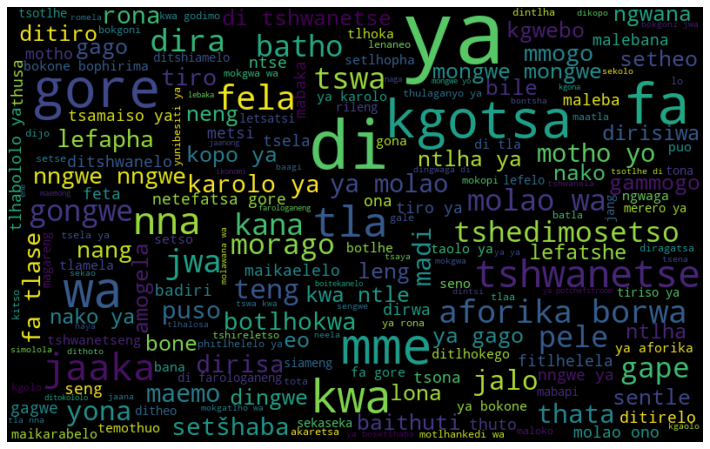

In [129]:
# Visualize Frequent words for 'tsn'; Tswana
tsn_words = " ".join([sentence for sentence in train_df['clean_text'][train_df['lang_id'] == 'tsn']])

wc = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(tsn_words)

# Plot the graph:
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

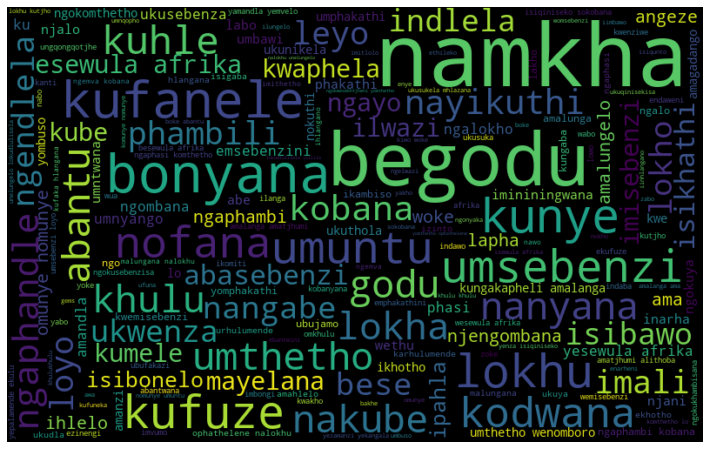

In [130]:
# Visualize Frequent words for 'nbl'; isiNdebele
nbl_words = " ".join([sentence for sentence in train_df['clean_text'][train_df['lang_id'] == 'nbl']])

wc = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(nbl_words)

# Plot the graph:
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

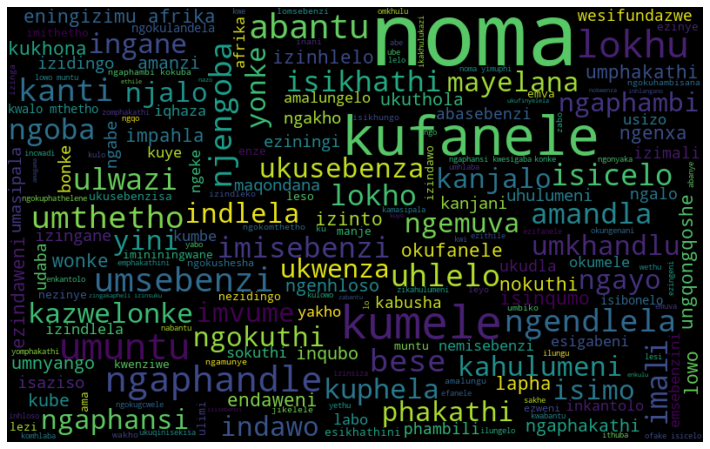

In [131]:
# Visualize Frequent words for 'zul'; Zulu 
zul_words = " ".join([sentence for sentence in train_df['clean_text'][train_df['lang_id'] == 'zul']])

wc = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(zul_words)

# Plot the graph:
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

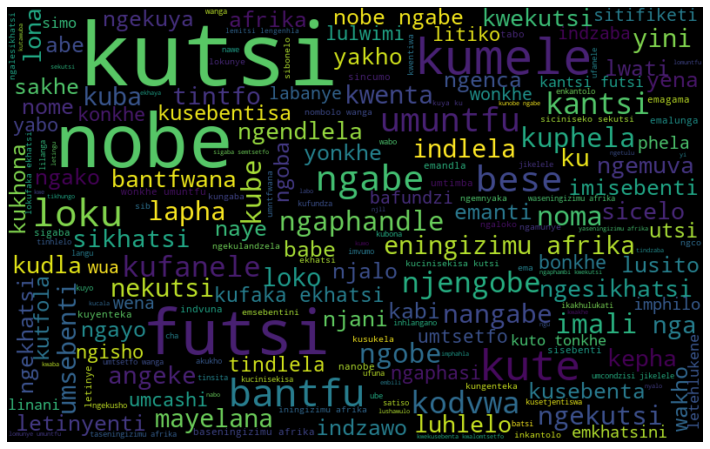

In [132]:
# Visualize Frequent words for 'ssw'; siSwati
ssw_words = " ".join([sentence for sentence in train_df['clean_text'][train_df['lang_id'] == 'ssw']])

wc = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(ssw_words)

# Plot the graph:
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

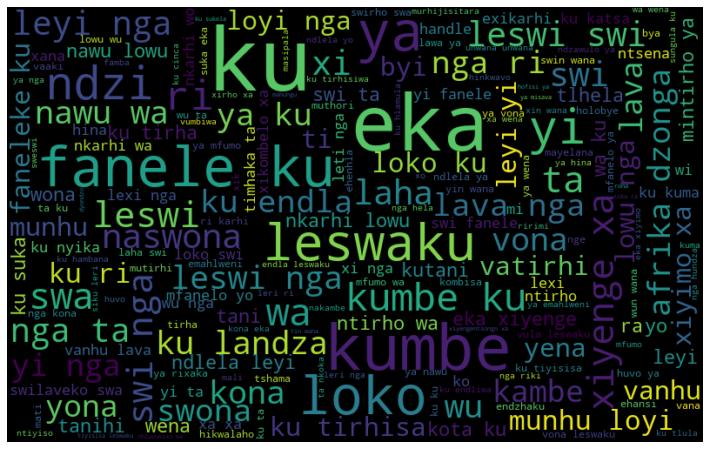

In [133]:
# Visualize Frequent words for 'tso'; Tsonga
tso_words = " ".join([sentence for sentence in train_df['clean_text'][train_df['lang_id'] == 'tso']])

wc = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(tso_words)

# Plot the graph:
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

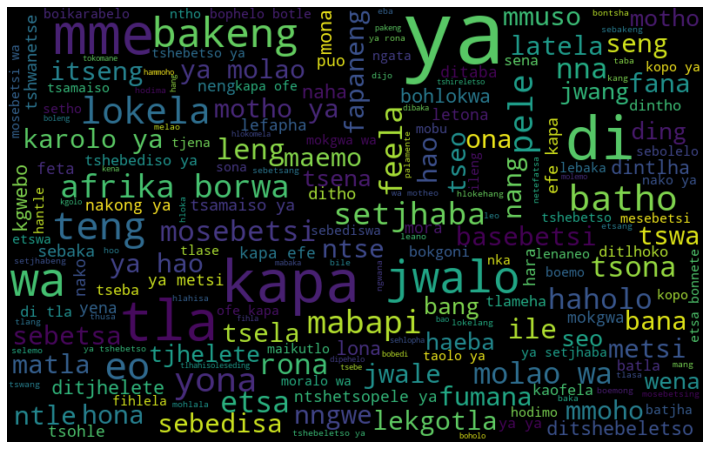

In [134]:
# Visualize Frequent words for 'sot'; Sesotho
sot_words = " ".join([sentence for sentence in train_df['clean_text'][train_df['lang_id'] == 'sot']])

wc = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(sot_words)

# Plot the graph:
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

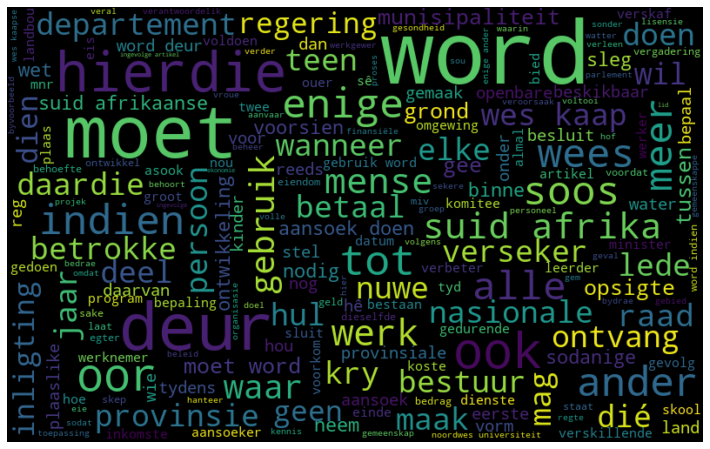

In [135]:
# Visualize Frequent words for 'afr'; Afrikaans 
afr_words = " ".join([sentence for sentence in train_df['clean_text'][train_df['lang_id'] == 'afr']])

wc = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(afr_words)

# Plot the graph:
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [136]:
# Drop the unused text column
train_df = train_df.drop(['text'], axis=1)
train_df.head()

lang_id                                         clean_text
0     xho  umgaqo siseko wenza amalungiselelo kumaziko ax...
1     xho  dha iya kuba nobulumko bokubeka umsebenzi naph...
2     eng  province kwazulu natal department transport in...
3     nso  netefatša gore file dilo moka tše dumelelanego...
4     ven  khomishini ya ndinganyiso ya mbeu yo ewa maana...

### Feature Engineering

First we will vectorise the data using Scikit-Learn's TfidfVectorizer. The text sentences are converted into a numerical feature matrix. Tfidf stands for Term frequency inverse document frequency, and the arguments I will use are:
* analyzer = 'char' 
* ngram_range = (1,3) 

Analyzer = 'char' tells the vectorizer to look at characters rather than words. ngram_range = (1,3) tells the vectorizer to assign tfidf scores to character sequences with max length of 3 characters and minimum length of 1 character. From doing some linguistic reasearch, I found that short character ngram sequences are predictive features of a natural languages.

In [137]:
vectorizer = feature_extraction.text.TfidfVectorizer(
    ngram_range=(1,3),
    analyzer='char'
)

In [138]:
X = train_df['clean_text']
X = vectorizer.fit_transform(X)
y = train_df['lang_id']

Next we will split the train data into train and test set with a ratio of 0.3 assigned for the test set. The parameter shuffle is set to true, so that the data set will be randomly shuffled before the split.

This data will be used in a number of models, including:
1. K-nearest neighbors (KNN)
2. Random Forest Classifier
3. Naive Bayes (Multinomial)
4. Logistic Regrssion
5. Gradient Boost Classifier

In [139]:
# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=45, shuffle=True)

In [140]:
# This function is used to evaluate model performance on train data
def show_performance_data(y_test, y_pred, model_name):
    """This function creates the confusion report as well as
    the language heatmap"""
    print(classification_report(y_test, y_pred, target_names=language_labels))
    
    tmp_result = classification_report(y_test, y_pred, 
                                       target_names=language_labels, 
                                       output_dict=True)
    
    cm1 = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm1, index = [i for i in language_labels], 
                         columns = [i for i in language_labels])
    plt.figure(figsize = (7,5))
    sns.heatmap(df_cm, annot=True, cmap='gist_earth_r', fmt='g')
    plt.savefig('confusion_mrtx_'+model_name+'.png',bbox_inches = 'tight')
    return tmp_result

### KNN
K-nearest neighbors algorithm is a non-parametric supervised learning method used for classification and regression. In both cases, the input consists of the k closest training examples in a data set.

In [ ]:
# Instantiate model object
knn = KNeighborsClassifier()

# Define the parameters for GridSearch
parameters = {'n_neighbors':[6,7,8],
              'leaf_size':[1],
              'algorithm':['auto', 'kd_tree'],
              'n_jobs':[-1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

neigh = GridSearchCV(knn, cv=cv, param_grid=parameters)
neigh.fit(x_train, y_train)
y_pred = neigh.predict(x_test)

print('The best parameters for KNN are:', end='\n\n')
print(neigh.best_params_)

results_knn = show_performance_data(y_test, y_pred, 'knn')

#### Save model as a file

In [ ]:
save_path = 'neigh.pkl'

with open(save_path, 'wb') as file:
    pickle.dump(neigh, file)

### Random Forest Classifier
Random forests or random decision forests is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time.

In [ ]:
# Instantiate model object
rf = RandomForestClassifier(random_state=1)

# Define the parameters for GridSearch
parameters = {
#    'bootstrap': [True],
    'max_depth': [None],
    'max_features': ['auto'], #, 'sqrt', 'log2'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 20, 30]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

rf_clf = GridSearchCV(rf, param_grid=parameters, 
                     cv = cv, n_jobs=-1, verbose=1)

rf_clf.fit(x_train, y_train)
y_pred = rf_clf.predict(x_test)

print('The best parameters for the Random Forest Classifier are:', end='\n\n')
print(rf_clf.best_params_)

result_rnmdfst = show_performance_data(y_test, y_pred, 'rndmfst')


#### Save model as file

In [ ]:
save_path = 'rf_clf.pkl'

with open(save_path, 'wb') as file:
    pickle.dump(rf_clf, file)

### Naive Bayes (Multinomial)
A naive Bayes classifier is an algorithm that uses Bayes' theorem to classify objects. Naive Bayes classifiers assume strong, or naive, independence between attributes of data points

In [ ]:
# Instantiate model object
nbm_clf = MultinomialNB().fit(x_train, y_train)
y_pred = nbm_clf.predict(x_test)
result_nbm = show_performance_data(y_test, y_pred, 'nbm')

In [ ]:
# Instantiate model object
nbm = MultinomialNB()

# Define the parameters for GridSearch
parameters = {
    'alpha':[1.0],
    'fit_prior':[True, False], 
    'class_prior':[None]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

nbm_clf = GridSearchCV(nbm, param_grid=parameters, cv = cv, n_jobs=-1, verbose=1)

nbm_clf.fit(x_train, y_train)

y_pred = nbm_clf.predict(x_test)

print('The best parameters for the Naive Bayes (Multinomial) Classifier are:', end='\n\n')
print(nbm_clf.best_params_)

result_nbm = show_performance_data(y_test, y_pred, 'nbm')

#### Save model as file

In [ ]:
save_path = 'nbm_clf.pkl'

with open(save_path, 'wb') as file:
    pickle.dump(nbm_clf, file)

### Logistic Regrssion
Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.

In [ ]:
# Instantiate model object
lr = LogisticRegression(random_state=0)

# Define the parameters for GridSearch
parameters = {'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'penalty':[None, 'l1', 'l2', 'elasticnet']
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

lr_clf = GridSearchCV(lr, param_grid=parameters, cv = cv, n_jobs=-1, verbose=1)

lr_clf.fit(x_train, y_train)

y_pred = lr_clf.predict(x_test)

print('The best parameters for the Logistic Regression Classifier are:', end='\n\n')
print(lr_clf.best_params_)

result_lr = show_performance_data(y_test, y_pred, 'lr')

#### Save model as file

In [ ]:
save_path = 'lr_clf.pkl'

with open(save_path, 'wb') as file:
    pickle.dump(lr_clf, file)

### Gradient Boost Classifier
Gradient boosting classifiers are a group of machine learning algorithms that combine many weak learning models together to create a strong predictive model. 

In [ ]:
# Instantiate model object
gb = GradientBoostingClassifier(random_state=0)

# Define the parameters for GridSearch
parameters = {'n_estimators': [10,15],
              'learning_rate':[1.0],
              'max_depth':[1]
}

# Set the folds
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Perform GridSearchCV
gb_clf = GridSearchCV(gb, param_grid=parameters, cv = cv, n_jobs=-1, verbose=1)

# Fit the best performing model
gb_clf.fit(x_train, y_train)

# Perform the prediction
y_pred = gb_clf.predict(x_test)

# Display the results
result_grdbst = show_performance_data(y_test, y_pred, 'grdbst')

#### Save model as file

In [ ]:
save_path = 'gb_clf.pkl'

with open(save_path, 'wb') as file:
    pickle.dump(gb_clf, file)

## Prediction

In [ ]:
# Apply the remove_punctuation function to test data
test_df['clean_text'] = test_df['text'].apply(text_cleanup)
# Tokenize the test data
test_df['clean_text'] = test_df['clean_text'].apply(tokenize_words)
# # Stem the test data
# test_df['clean_text'] = test_df['clean_text'].apply(lambda sentence: [stemmer.stem(word) for word in sentence])
# # Lemmatize the test data
# test_df['clean_text'] = test_df['clean_text'].apply(lambda sentence: [lemmatizer.lemmatize(word) for word in sentence])
# Remove stop words from test data
test_df['clean_text'] = test_df['clean_text'].apply(remove_stop_words)

In [ ]:
# Apply the back_to_sentence function
test_df['clean_text'] = test_df['clean_text'].apply(back_to_sentence)
test_df.head()

In [ ]:
test_df = test_df.drop(['text'], axis=1)
test_df.head()

In [ ]:
test_df.shape

#### KNN Pickle

In [ ]:
# model_path = 'neigh.pkl'
# with open(model_path, 'rb') as file:
#     unpickled_model = pickle.load(file)

#### Random Forest Pickle

In [ ]:
# model_path = 'rf_clf.pkl'
# with open(model_path, 'rb') as file:
#     unpickled_model = pickle.load(file)

#### Naive Bayes Multinomial Pickle

In [ ]:
model_path = 'nbm_clf.pkl'
with open(model_path, 'rb') as file:
    unpickled_model = pickle.load(file)

#### Logistic Regression Pickle

In [ ]:
# model_path = 'lr_clf.pkl'
# with open(model_path, 'rb') as file:
#     unpickled_model = pickle.load(file)

#### Gradient Boost Pickle

In [ ]:
# model_path = 'gb_clf.pkl'
# with open(model_path, 'rb') as file:
#     unpickled_model = pickle.load(file)

#### Prediction

In [ ]:
X = test_df['clean_text']
X = vectorizer.transform(X)

In [ ]:
# Test Set Predictions:
y_hat = unpickled_model.predict(X)

In [ ]:
# Creating data frame for the predicted values:
predictions = pd.DataFrame()
predictions['index'] = test_df['index']
predictions['lang_id'] = y_hat
predictions.set_index('index', inplace=True)


In [ ]:
predictions.tail()

In [ ]:
# Save prediction as .csv:
predictions.to_csv('NaiveBFinal.csv')